In [1]:
import numpy as np
import gym
env = gym.make("LunarLander-v2")
input_shape = env.observation_space.shape
n_outputs = env.action_space.n
input_shape, n_outputs

((8,), 4)

In [2]:
import tensorflow as tf
from tensorflow import keras

# model that predicts Q-value for each action according to an input state
print(env.reset()[np.newaxis, :])
print(env.action_space.n)
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=input_shape))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(n_outputs))
model(env.reset()[np.newaxis, :])
model_initial_weights = model.get_weights()

/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resam

[[-0.00656195  1.4008385  -0.66465205 -0.44810185  0.00761025  0.15055348
   0.          0.        ]]
4
[array([[-0.09903736,  0.17859298, -0.05863473,  0.2592715 , -0.07335472,
        -0.28002197,  0.28865498,  0.23654294, -0.15122534, -0.08304651,
        -0.12724048, -0.17281577, -0.04082929,  0.19433147, -0.01142415,
        -0.28498465,  0.27361947, -0.19088921,  0.27855378, -0.2246162 ,
        -0.16157147, -0.20235266, -0.13448326, -0.17097408,  0.16140899,
         0.13659793,  0.06366396,  0.23630738,  0.10436025,  0.11946836,
         0.25097013, -0.24314147,  0.04193518,  0.17399964, -0.25272626,
        -0.12950829, -0.145994  , -0.09977366,  0.17651969,  0.03697664,
         0.12972847,  0.09760222, -0.03039989, -0.20681068, -0.18662044,
        -0.20836022,  0.14372516, -0.16393721, -0.07281457,  0.01604337,
         0.23678708,  0.14958873, -0.16832663, -0.16241658, -0.24132662,
         0.12624031, -0.24545209, -0.15861782,  0.040548  ,  0.0296576 ,
        -0.20865405

2022-06-01 17:06:41.322731: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis, :])
        return np.argmax(Q_values[0])
epsilon_greedy_policy(env.reset())

2

In [4]:
from collections import deque

# el: state, action, reward, next_state, done
replay_buffer = deque(maxlen=2000)

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    experiences = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [np.array([exp[col] for exp in experiences]) for col in range(5)]
    return states, actions, rewards, next_states, dones

# replay_buffer = [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14]]
# sample_experiences(2)

In [5]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    obs, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, obs, done))
    return obs, reward, done, info

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.56it/s]

-188.7587532977726 104.56954739954841 -458.9020241689637 29.917423546009218
[array([[-0.09903736,  0.17859298, -0.05863473,  0.2592715 , -0.07335472,
        -0.28002197,  0.28865498,  0.23654294, -0.15122534, -0.08304651,
        -0.12724048, -0.17281577, -0.04082929,  0.19433147, -0.01142415,
        -0.28498465,  0.27361947, -0.19088921,  0.27855378, -0.2246162 ,
        -0.16157147, -0.20235266, -0.13448326, -0.17097408,  0.16140899,
         0.13659793,  0.06366396,  0.23630738,  0.10436025,  0.11946836,
         0.25097013, -0.24314147,  0.04193518,  0.17399964, -0.25272626,
        -0.12950829, -0.145994  , -0.09977366,  0.17651969,  0.03697664,
         0.12972847,  0.09760222, -0.03039989, -0.20681068, -0.18662044,
        -0.20836022,  0.14372516, -0.16393721, -0.07281457,  0.01604337,
         0.23678708,  0.14958873, -0.16832663, -0.16241658, -0.24132662,
         0.12624031, -0.24545209, -0.15861782,  0.040548  ,  0.0296576 ,
        -0.20865405, -0.1226185 , -0.22122365, 

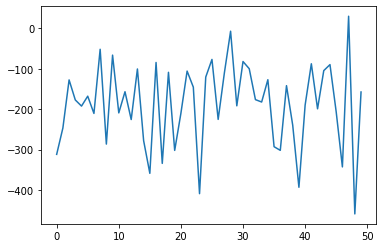

In [6]:
# training
from tqdm import tqdm
import matplotlib.pyplot as plt

batch_size = 32
discount_factor = 0.97
optimizer = keras.optimizers.Adam(0.0001)
loss_fn = keras.losses.mean_squared_error
n_episodes = 750
n_steps = 200

def training_step(batch_size):
    states, actions, rewards, next_states, dones = sample_experiences(batch_size)
    next_Q_values = model.predict(next_states)
    max_next_Q_values = tf.reduce_max(next_Q_values, axis=1) # agent plays optimally => store only max values
    target_Q_values = rewards + (1 - dones) * discount_factor * max_next_Q_values
    mask = tf.one_hot(actions, n_outputs) 
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(mask * all_Q_values, axis=1, keepdims=True) # mask out q values for actions that were not chosen 
        loss = tf.reduce_mean(loss_fn(Q_values, target_Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

def train():
    episode_rewards = []
    for episode in tqdm(range(n_episodes)):
        obs = env.reset()
        step_reward = 0
        for step in range(n_steps):
            eps = max(1 - episode / 500, 0.01)
            obs, reward, done, info = play_one_step(env, obs, eps)
            step_reward += reward
            if done:
                break
        episode_rewards.append(step_reward)
        if episode > 50:
            training_step(batch_size)
    return episode_rewards
episode_rewards = train()
print(np.mean(episode_rewards), np.std(episode_rewards), np.min(episode_rewards), np.max(episode_rewards))
# -359.2941391120138 219.35082075916458 -1486.1583193369427 98.2295202449274 lr = 0.001
# -357.13935431215975 190.29114724718954 -1341.4294567761463 18.40714374846098 lr = 0.001

plt.plot(episode_rewards)

In [ ]:
model.get_weights()

[array([[-1.00438535e-01,  1.77946702e-01, -6.02239482e-02,
          2.55872488e-01, -7.56477341e-02, -2.79660821e-01,
          2.88818747e-01,  2.35242352e-01, -1.51559606e-01,
         -8.05705190e-02, -1.27215862e-01, -1.69294253e-01,
         -3.75357009e-02,  1.95294574e-01, -1.12936236e-02,
         -2.81368524e-01,  2.73718745e-01, -1.91469893e-01,
          2.81958252e-01, -2.23247722e-01, -1.59330592e-01,
         -2.05455080e-01, -1.35969892e-01, -1.72752112e-01,
          1.61201566e-01,  1.35004520e-01,  6.13388121e-02,
          2.36350268e-01,  1.06083587e-01,  1.22286156e-01,
          2.53607959e-01, -2.42155418e-01,  4.10013720e-02,
          1.73101380e-01, -2.55686224e-01, -1.29257321e-01,
         -1.42626151e-01, -9.84412357e-02,  1.79118708e-01,
          3.50331292e-02,  1.28576219e-01,  9.80270430e-02,
         -3.00494935e-02, -2.07941622e-01, -1.90275595e-01,
         -2.06647098e-01,  1.44379139e-01, -1.61756396e-01,
         -7.43210390e-02,  1.31252808e-0

### DQN variants

In [1]:
def fixed_q_value_targets():
    model.set_weights(model_initial_weights)
    target = keras.models.clone_model(model)
    target.set_weights(model.get_weights())
    def training_step_fixed_q_value_targets(batch_size):
        states, actions, rewards, next_states, dones = sample_experiences(batch_size)
        next_Q_values = target.predict(next_states)
        max_next_Q_values = tf.reduce_max(next_Q_values, axis=1) # agent plays optimally => store only max values
        target_Q_values = rewards + (1 - dones) * discount_factor * max_next_Q_values
        mask = tf.one_hot(actions, n_outputs) 
        with tf.GradientTape() as tape:
            all_Q_values = model(states)
            Q_values = tf.reduce_sum(mask * all_Q_values, axis=1, keepdims=True) # mask out q values for actions that were not chosen 
            loss = tf.reduce_mean(loss_fn(Q_values, target_Q_values))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    def train_fixed_q_value_targets():
        episode_rewards = []
        for episode in tqdm(range(n_episodes)):
            obs = env.reset()
            step_reward = 0
            for step in range(n_steps):
                eps = max(1 - episode / 500, 0.01)
                obs, reward, done, info = play_one_step(env, obs, eps)
                step_reward += reward
                if done:
                    break
            episode_rewards.append(step_reward)
            if episode > 50:
                training_step_fixed_q_value_targets(batch_size)
            if episode % 50 == 0:
                target.set_weights(model.get_weights())
        return episode_rewards
    episode_rewards = train()
    print(np.mean(episode_rewards), np.std(episode_rewards), np.min(episode_rewards), np.max(episode_rewards))
fixed_q_value_targets()

here


NameError: name 'tqdm' is not defined